In [16]:
import mne
import os
import re

# load data, I'm using NDARAA396TWZ and NDARAA773LUW as samples
resting_state_path = "sub-NDARAA396TWZ_task-RestingState_eeg.set"
contrast_change_path = "sub-NDARAA773LUW_task-contrastChangeDetection_run-1_eeg.set"

raw_data = []
raw_dir = os.path.join('..', '..', 'raw')
for file_name in [resting_state_path, contrast_change_path]:
    file_path = os.path.join(raw_dir, file_name)
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    raw_data.append(raw)

resting_state, contrast_change = raw_data
resting_state_sfreq = resting_state.info['sfreq']
contrast_change_sfreq = contrast_change.info['sfreq']

In [17]:
resting_state_csv = resting_state.to_data_frame()
contrast_change_csv = contrast_change.to_data_frame()

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

empirical_headers = contrast_change.ch_names
empirical_eeg = contrast_change.get_data()

class printFormat:
    bold = '\033[1m'
    italic = '\033[3m'
    end = '\033[0m'

#Print the head of the data
print(printFormat.bold + 'Display Header and first few rows/columns of data\n \033[0m' + printFormat.end)
print(pd.DataFrame(empirical_eeg.T, columns=empirical_headers).iloc[:5,:6])

#Print some information about the columns
print('\n' + '-'*90)
print(f"{printFormat.bold}\nNote the first four columns:{printFormat.end}\n"
      f"    ParticipantID - Indicates different participants\n"
      f"    Condition - Indicates the condition (WIN = 0, LOSE = 1) to be classified\n"
      f"    Trial - Indicates the trial number for that participant and condition\n"
      f"    Electrode - a numerical number ID of each electrode")
print('\nThe remaining columns are titled Time1 to Time100 - indicating 100 datapoints per sample.\n'
      'The samples span from -200 to 1000ms around the onset of a feedback stimulus.\n'
      'These are downsampled from the original data, which contained 600 datapoints per sample.')

Display Header and first few rows/columns of data
 
         E1        E2        E3        E4        E5        E6
0 -0.005971 -0.010148 -0.003549 -0.004837  0.001780 -0.000222
1 -0.005925 -0.010107 -0.003516 -0.004809  0.001805 -0.000285
2 -0.005885 -0.010074 -0.003488 -0.004774  0.001847 -0.000311
3 -0.005879 -0.010062 -0.003483 -0.004741  0.001890 -0.000234
4 -0.005922 -0.010093 -0.003513 -0.004732  0.001915 -0.000077

------------------------------------------------------------------------------------------

Note the first four columns:
    ParticipantID - Indicates different participants
    Condition - Indicates the condition (WIN = 0, LOSE = 1) to be classified
    Trial - Indicates the trial number for that participant and condition
    Electrode - a numerical number ID of each electrode

The remaining columns are titled Time1 to Time100 - indicating 100 datapoints per sample.
The samples span from -200 to 1000ms around the onset of a feedback stimulus.
These are downsampled fro

Used Annotations descriptions: ['break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
Event IDs found in the data: {'break cnt': 1, 'instructed_toCloseEyes': 2, 'instructed_toOpenEyes': 3, 'resting_start': 4}
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13 events and 601 original time points ...
2 bad epochs dropped


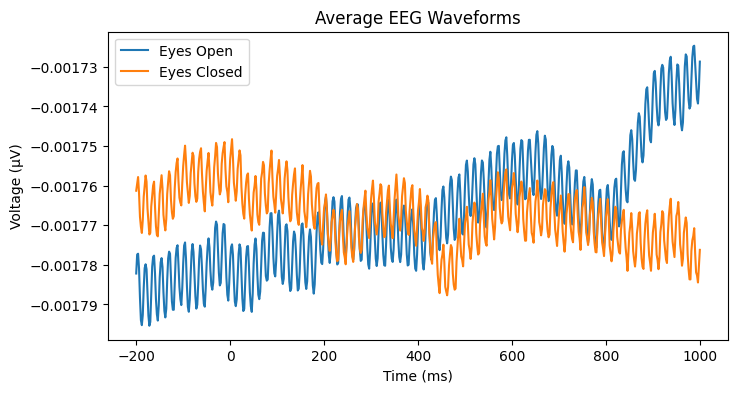

In [19]:
events, event_id = mne.events_from_annotations(resting_state)

print(f"{printFormat.bold}Event IDs found in the data:{printFormat.end} {event_id}")

epochs = mne.Epochs(resting_state, events, event_id=event_id, tmin=-0.2, tmax=1.0, baseline=None, preload=True)

eyes_open = epochs['instructed_toOpenEyes'].get_data()
eyes_closed = epochs['instructed_toCloseEyes'].get_data()

# Average across trials & electrodes
open_avg = eyes_open.mean(axis=0).mean(axis=0)
closed_avg = eyes_closed.mean(axis=0).mean(axis=0)

# Plot average EEG waveforms
time = epochs.times * 1000  # convert s → ms
plt.figure(figsize=(8, 4))
plt.plot(time, open_avg, label='Eyes Open')
plt.plot(time, closed_avg, label='Eyes Closed')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (μV)')
plt.title('Average EEG Waveforms')
plt.legend()
plt.show()

In [20]:
def epochs_to_df(epochs, condition_name):
    data = epochs.get_data()
    n_epochs, n_channels, n_times = data.shape
    df_list = []

    for trial_idx in range(n_epochs):
        for ch_idx in range(n_channels):
            row = {
                'ParticipantID': 1,  # if you have multiple participants, fill properly
                'Condition': 0 if condition_name == 'EyesOpen' else 1,
                'Trial': trial_idx + 1,
                'Electrode': ch_idx + 1
            }
            # Add timepoints as Time1, Time2, ...
            for t in range(n_times):
                row[f'Time{t+1}'] = data[trial_idx, ch_idx, t]
            df_list.append(row)

    return pd.DataFrame(df_list)

# Convert MNE epochs to EEG-GAN format
df_open = epochs_to_df(epochs['instructed_toOpenEyes'], 'EyesOpen')
df_closed = epochs_to_df(epochs['instructed_toCloseEyes'], 'EyesClosed')

# Combine
df_all = pd.concat([df_open, df_closed], ignore_index=True)
df_all.head()

,ParticipantID,Condition,Trial,Electrode,Time1,Time2,Time3,Time4,Time5,Time6,...,Time592,Time593,Time594,Time595,Time596,Time597,Time598,Time599,Time600,Time601
0,1,0,1,1,-0.028187,-0.028166,-0.028152,-0.028168,-0.028185,-0.028198,...,-0.028300,-0.028290,-0.028270,-0.028268,-0.028290,-0.028304,-0.028328,-0.028335,-0.028314,-0.028304
1,1,0,1,2,-0.012799,-0.012783,-0.012771,-0.012787,-0.012802,-0.012813,...,-0.012856,-0.012847,-0.012826,-0.012825,-0.012846,-0.012858,-0.012880,-0.012886,-0.012866,-0.012856
2,1,0,1,3,-0.010889,-0.010874,-0.010862,-0.010876,-0.010890,-0.010901,...,-0.010939,-0.010931,-0.010910,-0.010908,-0.010930,-0.010941,-0.010961,-0.010968,-0.010951,-0.010940
3,1,0,1,4,-0.005877,-0.005862,-0.005849,-0.005863,-0.005876,-0.005887,...,-0.005911,-0.005903,-0.005881,-0.005880,-0.005901,-0.005912,-0.005933,-0.005940,-0.005922,-0.005911
4,1,0,1,5,-0.005373,-0.005359,-0.005348,-0.005361,-0.005372,-0.005382,...,-0.005403,-0.005396,-0.005378,-0.005375,-0.005394,-0.005403,-0.005420,-0.005427,-0.005412,-0.005402


In [21]:
df_all.to_csv('my_eeg_data.csv', index=False)